In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import pandas as pd
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings("ignore")
from pylab import meshgrid  
from matplotlib import cm as cm
import os

### Review of lecture 26


In Lecture 26 we learned a  bit about time series data and time series analysis.  We applied simple techniques to time series of Earth's orbital parameters and records that reflect past ice volume - key support for the Milankovitch hypothesis.  

#### In this lecture we will:

-  Learn simple way to make animated gifs.






### Animation with Python

To really do animation - like making cartoons - you need some pretty fancy software.  There are modules in the Python package **mayavi** that are pretty powerful, but that is way beyond the scope of this class.  Also, **mayavi** is not yet supported in Python 3, so we can't do it anyway...   

However,   you 
CAN make some simple animated gifs with a Python package called **imageio** (which by the way does not come with the Python package we are using for this class, but can be installed pretty easily.  In this class we will work through two examples, one building on the map of the geomagnetic field intentsity that we saw before in the lecture on contouring and one on the motion of the Indian plate since it rifted off of Aftica.  

The key to making an animated gif is to generate a series of images that together make the movie.  The first part we already know how to do, but now we learn how to stitch them together.  

### One hundred years of the Earth's magnetic field

In this folder there  is a modified version of the **magmap** function we used in Lecture 21.  It has the map making function embedded in it and will generate a map using the International Geomagnetic Reference Field model for any date between 1900 and 2020.

But before we go on, what IS the IGRF?  It is a model for the magnetic field which starts with the premise that
magnetic fields (vectors) can be calculated from the gradient of a scalar potential field (${\bf H}=-\nabla \psi_m$). The scalar potential field satisfies Laplace's Equation: 

$ \nabla^2 \psi_m = 0$.  

For the geomagnetic field (ignoring external sources of the magnetic field which are in any case small and transient), the potential equation can be written  as:

 $ \psi_m (r,\theta,\phi)={a\over{ \mu_o} } \sum_{l=1}^\infty  \sum_{m=0}^l \left( {a \over
r}\right)^{l+1} P_l^m (\cos \theta)
\left(g_l^m  \cos m\phi  + h_l^m \sin m\phi\right),
$

where $a$ is the radius of the
Earth ($6.371$ x  $10^6$ m).    In addition to the radial distance $r$ and the angle away from the pole $\theta$, there is $\phi$, the angle around the equator from some reference, say, the Greenwich meridian. $\theta$ is the co-latitude and $\phi$ is the longitude. 
The  $g_l^m$s and $h_l^m$s are the
_gauss coefficients_ (degree $l$ and order $m$)   for hypothetical sources at radii less than $a$
calculated for a particular year. These are normally given in units of nanotesla.  The
$P_l^m$s are  wiggly functions called partially normalized 
Schmidt polynomials of the argument $\cos \theta$. These are closely related to the associated
 Legendre polynomials.   The first few of $P_l^m$s are: 
$$
P_1^0=\cos \theta, P_2^0 = {1\over 2}(3\cos^2\theta -1), \hbox{ and }	
P_3^0 = {1\over 2}\cos \theta(5\cos^3\theta -3\cos \theta ),
$$

which we can plot here:  



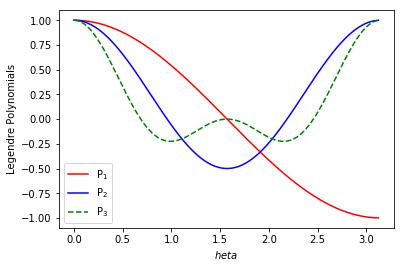

In [2]:
P1 = lambda theta: np.cos(theta)
P2= lambda theta: 0.5*(3.*np.cos(theta)**2-1.)
P3 = lambda theta: 0.5*np.cos(theta)*(5.*np.cos(theta)**3-3.*np.cos(theta))

thetas=np.radians(np.arange(0,180)) # make an array of thetas from 0 to pi
P1s=P1(thetas) # evaluate the first Legendre polynomial
P2s=P2(thetas) #second
P3s=P3(thetas) # third
plt.plot(thetas,P1s,'r-',label='P$_1$') # plot the first
plt.plot(thetas,P2s,'b-',label='P$_2$')
plt.plot(thetas,P3s,'g--',label='P$_3$')
plt.xlabel('$\theta$') # label X axis
plt.ylabel('Legendre Polynomials') # label Y
plt.legend(loc=3); # put on a legend

So, like the Fourier transform we learned about in the last lecture, these functions could be used to make a 'spherical harmonic analysis' of spherical data like the Earth's magnetic field.  From observations of the magnetic field around the Earth, we can fit these equations with the Gauss Coefficients and use the potential equation to 
 predict magnetic field vectors anywhere outside the source (the outer core). 
 
 New lists are compiled every five years or so and you can download them from here:  https://www.ngdc.noaa.gov/IAGA/vmod/igrf.html
I downloaded IGRF12 file and put it into a module called **mkigrf** along with functions to do the calculations.   

OK.  Let's work through this script first:  

In [3]:
import mkigrf  # import the module


def magmap2png(date,lon_0,element):
    """
    Generates a map of the desired geomagnetic element.  
    Inputs: 
        date: decimal year
        lon_0: central longitude for the map
        element: desired field element for the map
            Allowed elements are:
            D (declination), 
            I (inclination), 
            B (total field strength), and 
            R (radial field strength)
    Output: 
        Hammer projection of desired element saved  to a .jpg file with the field element 
        and date in the file name. 
    """
    incr=5 # this sets the lat/lon grid size of the field model in degrees
    # adjust geographic bounds for the desired resolution. 
    # Remember that % is for the modulo and makes sure that the longitudes are 0-360 range
    lonmax=(lon_0+180.)%360+incr # maximum longitude for the array
    lonmin=(lon_0-180.) # minimum longitude
    latmax=90+incr 
    lons=np.arange(lonmin,lonmax,incr) # makes an array of longitudes
    lats=np.arange(-90,latmax,incr) # same for latitudes 
    # sets up some containers we might want
    B=np.zeros((len(lats),len(lons)))  # 2D array of lats and lons
    Binc=np.zeros((len(lats),len(lons)))
    Bdec=np.zeros((len(lats),len(lons)))
    Brad=np.zeros((len(lats),len(lons)))
    for j in range(len(lats)): # steps through all the latitudes
        for i in range(len(lons)): # and the longitudes
            x,y,z,f=mkigrf.doigrf(lons[i],lats[j],date) # evaluates the field at place and time
            Dec,Inc,Int=mkigrf.cart2dir(x,y,z) # converts to declination, inc, strength
            B[j][i]=Int*1e-3 # converts from nT to microtesla
            Binc[j][i]=Inc
            Bdec[j][i]=Dec
            Brad[j][i]=z*1e-3 # converts from nT to microtesla
# make the map
    # assigns array mag to desired element
    if element=='B':
        mag=np.array(B)
        title='Field strength ($\mu$T) '
    elif element=='D':
        mag=np.array(Bdec)
        title='Declination '
    elif element=='I':
        mag=np.array(Binc)
        title='Inclination '
    elif element=='R':
        mag=np.array(Brad)
        title='Radial'
    plt.clf() # clears the plot in case you call it multiple times
    m = Basemap(projection='hammer',lon_0=lon_0) # creates the map object
    x,y=m(*meshgrid(lons,lats)) # makes a grid of the lons and lats
    m.drawcoastlines() # puts on the coastlines
    cs=m.contourf(x,y,mag,levels=np.arange(20,75,5),cmap=cm.RdYlBu) # makes the contour map with fixed levels
    cbar=m.colorbar(cs,location='bottom') # puts the color bar at the bottom
    plt.title(title+str(date)) # puts on the title
    if element=='B':title='Intensity' # renames the title to take out spaces
    plt.savefig('Maps/'+title.strip()+'_'+str(date)+'.png') # saves the  figure. to a folder



Now we need a little for loop to generate maps for the desired element and date range. But first, we need a place to put them.  We can tell if that directory already exists by getting a listing of our working directory.  If it doesn't we can make a directory called 'Maps'.  Then we can clear it out, in case there are any maps left over from a previous attmept. 

In [4]:

L=os.listdir("./")
if 'Maps' not in L:
    os.mkdir('Maps')
!rm Maps/*.png 



And now we can make a bunch of maps. Warning:  it takes a while to do this. 

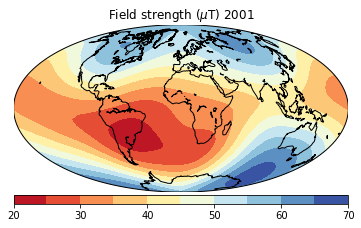

In [5]:
dates=range(1900,2018,10) # make maps for these years.  
lon_0=0 # center the maps at the Greenwich meridian
element='B' # let's do field strength
for date in dates:  # step through the loop
    magmap2png(date,lon_0,element) # make the maps



Once we've made all the maps, we can put them into an animation using a module called imageio.  To use imageio, you will have to first install it. The most convenient way to do this is using 'pip install update imageio'. Uncomment that line if you need to install it.  

In [6]:
#!pip install update imageio
import imageio # and let's go ahead and import it.  

And now we can run it.  

We can use the function os.listdir to get a list of files in the 'Maps' directory. Then work through the files with the **imageio.imread()** function.  Then save the collected images to an animated gif file.  :) 

In [16]:
filenames=os.listdir('Maps/') # listing of the directory
images = [] # make a container to put the image files in
for file in filenames: # step through all the maps
    if '.png' in file: # skip some of the nasty hidden files
        filename='Maps/'+file # make filename from the folder name and the file name
        images.append(imageio.imread(filename)) # read it in and stuff in the container
imageio.mimsave('Maps/Bmovie.gif', images) # save to an animated gif.  

To watch the video, just choose 'Open' from the File menu, find the gif and open it.  :)  

OR, to embed it in a notebook, here's a handy trick:

In [17]:
from IPython.display import HTML
HTML('<img src="Maps/Bmovie.gif">')

### Continental Drift - the movie

The idea of continental drift, controversial for the first half of the 20$^{th}$ century, was basically proven in the 50s by the concept of apparent polar wander.  So what is apparent polar wander? By assuming that the magnetic field is generated by a magnetic dipole at the center of the Earth and that it is constrained to be aligned with the spin axis, it is possible to determine the position of the spin axis through time.   In the 50s it was recognized that this pole seemed to move with respect to the spin axis, so 
this  apparent wandering  could be interpreted in two ways:  wandering of continents whose paleomagnetic directions reflect the changing orientations and distances to the (fixed) pole (lefthand figure below), or alternatively, the pole itself could be wandering, as in righthand figure while the continent remains fixed.  



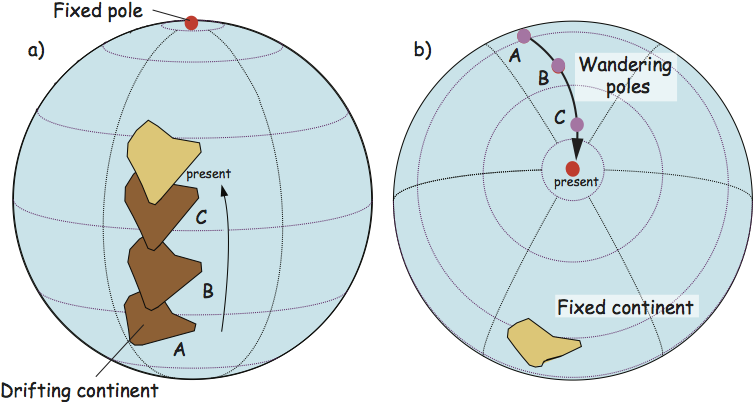

In [17]:
Image(filename='Figures/wandering.png',width=500)


_a) A moving continent will retain a record of changing paleomagnetic directions through time that reflect the changing orientations and distances to the pole (which is held fixed).  The resulting path of observed pole positions is called an "apparent polar wander path" or APWP because in this case the pole is actually fixed and only appears to move when viewed from the continental frame of reference.   b) On the other hand, if a continent is held fixed, the same changing paleomagnetic directions reflect the wandering of the pole itself.  This is called "true polar wander" or TPW. [Figure from Essentials of Paleomagnetism by Tauxe et al.,(2010): 
https://earthref.org/MagIC/books/Tauxe/Essentials/]_

Data from a single continent cannot distinguish between these two hypotheses.   But data from multiple continents and  a firm belief in the essential dipolar nature of the geomagnetic field (dating back to 1600!) can.  If the pole paths from two or more continents diverge back in time and there is a dipolar field (only one north pole), then it must be the continents  that are doing the wandering.   It was data of this kind that
convinced paleomagnetists in the 50s of the reality of continental drift.    

Well after the concept of continental drift and apparent polar wander had been accepted by most of the paleomagnetic community, the idea of sea-floor spreading and plate tectonics was developed to explain it.  In plate tectonics, the hard outer shell of the Earth, the _lithosphere_  is composed of many rigid or semi-rigid plates.     These plates are in constant motion with respect to one another.  The relative motion of two plates can be described by  rotation about an Euler rotation vector, which is usually specified by a pole latitude/longitude on the surface of the Earth ($\lambda_{e},\phi_e$) and a rotation rate $\omega$ in $^{\circ}$Myr$^{-1}$.  The velocity $v$ at a given point  on a plate with respect to its "fixed" partner varies as a function of angular distance from the Euler pole ($\theta$) as:

$ v = a \omega \sin \theta,$

where $a$ is the radius of the Earth.     As an example, the figure below shows the motion of North America (NAM) with respect to "fixed" Europe (EUR).  The current Euler pole
is the square.  Lines of co-latitude correspond to     $\theta$ in this projection, so the velocities  (usually expressed in cm/yr; see black arrows in the right hand figure increase away from the pole, with a maximum at $\theta = 90^{\circ}$. Beyond 90$^{\circ}$ the velocities decrease to the antipode of the Euler pole.   Spreading rates can be determined from marine magnetic anomalies and  their variation along the ridge crest can be fit with the spreading rate equation to find both $\omega$ and $\theta$, and helping to constrain the location of the Euler pole.



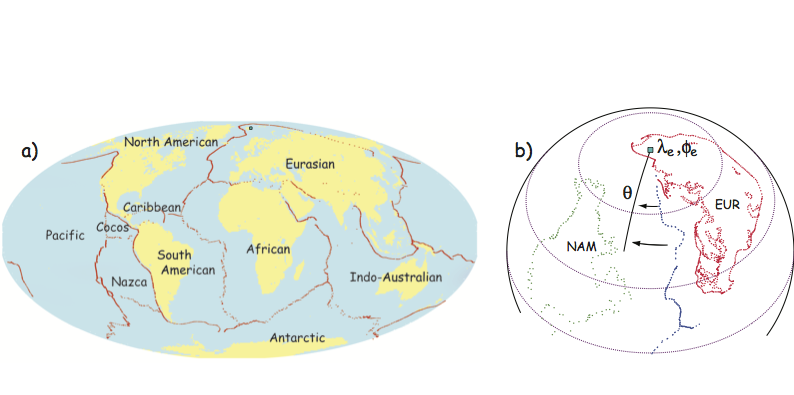

In [19]:
Image(filename='Figures/plates.png')

_a) Some of the major lithospheric plates.  b) Motion of North America with respect to Europe around the Euler pole shown as a blue square.  Projection is such that current Euler pole North America (NAM) with respect to Europe (EUR) is at the "North pole".  Lines of co-latitude are the angular distance from the Euler pole, $\theta$.  Velocities of NAM with respect to EUR at two points with different $\theta$ are shown as black arrows.  [Figure from Essentials of Paleomagnetism by Tauxe et al.,(2010): 
https://earthref.org/MagIC/books/Tauxe/Essentials/]_






### Euler rotations and finite rotations


Euler poles describe instantaneous rates of rotation of one plate or continental fragment with respect to another.  Often, what is known is not the rate, but the total rotation about a given pole that restores a plate to some prior state.  Such a pole is called a 
_finite rotation pole_. 



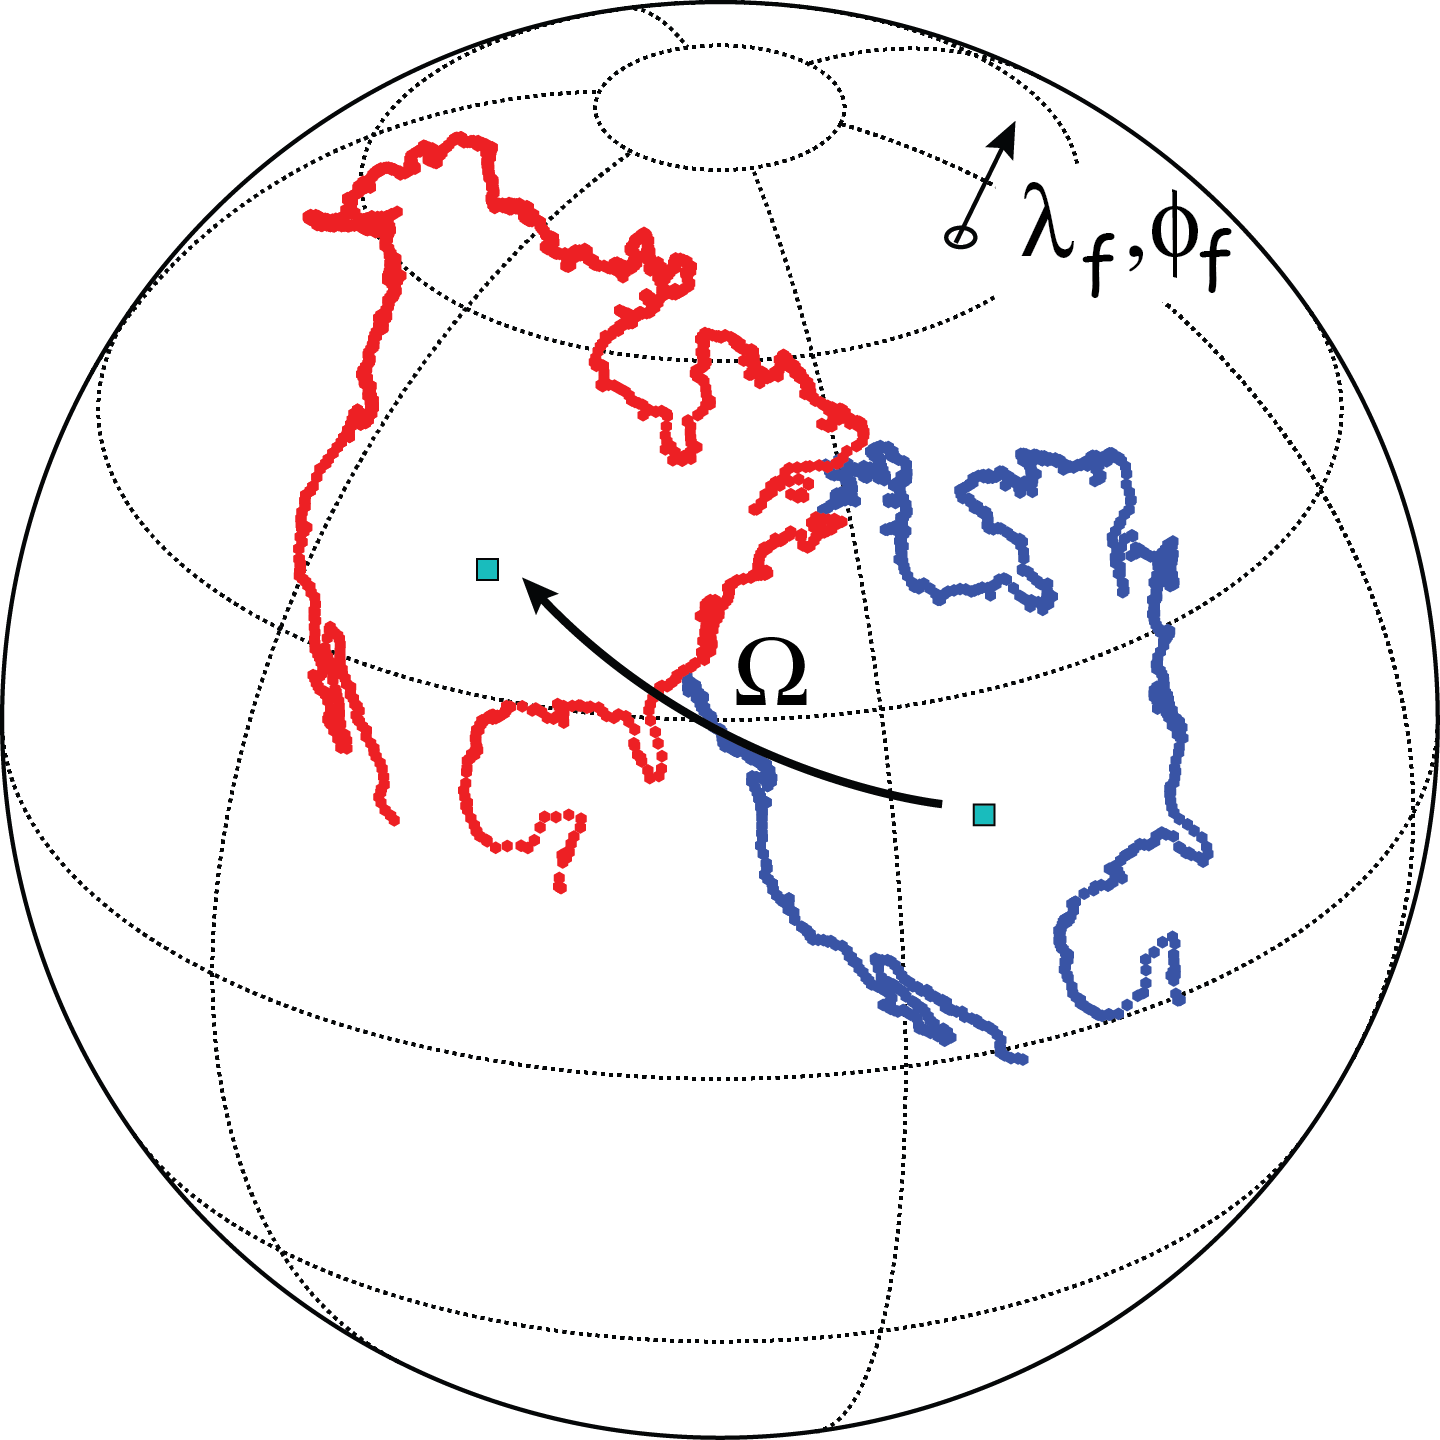

In [20]:
Image(filename='Figures/finrot.png',width=300)

Finite rotation of North America from one frame of reference to another.  Finite rotation pole is located at $\lambda_f,\phi_f$ and the finite rotation is $\Omega$. [Figure from Essentials of Paleomagnetism by Tauxe et al.,(2010): 
https://earthref.org/MagIC/books/Tauxe/Essentials/]

A huge amount of work has been put into compiling finite rotations for various lithospheric plates through time. 
Using these poles of rotation, the points defining a particular continental fragment can be rotated back through time as was done  for the picture of India moving north above,  which is in fact a series of reconstructions of the Indian subcontinent consistent with paleomagnetic poles determined at intervals for the last  80 Ma.  Now we can make the movie version.  

All we need are the continental outlines (which I put into the module **continents**) and the finite rotations which I put into a module called **poleRot** for your rotation pleasure.  There is a directory called **ContRot** for storing the images in (just like we did for the magnetic field maps.  

So to get started, a little housekeeping:






In [21]:
!rm ContRot/*.jpg
import poleRot
help(poleRot)


rm: ContRot/*.jpg: No such file or directory
Help on module poleRot:

NAME
    poleRot

FUNCTIONS
    PTrot(EP, Lats, Lons)
        Does rotation of points on a globe  by finite rotations, using method of Cox and Hart 1986, box 7-3.
    
    cart2dir(cart)
        Converts a direction in cartesian coordinates into declination, inclinations
        
        Parameters
        ----------
        cart : input list of [x,y,z]
        
        Returns
        -------
        direction_array : returns an array of [declination, inclination, intensity]
    
    dir2cart(d)
        Converts a list or array of vector directions in degrees (declination,
        inclination) to an array of the direction in cartesian coordinates (x,y,z)
        
        Parameters
        ----------
        d : list or array of [dec,inc] or [dec,inc,intensity]
        
        Returns
        -------
        cart : array of [x,y,z]
    
    get_continent(continent)
        Returns the continental outlines (latitude

We can make the map of  Africa (assumed fixed) and India in their present positions by retrieving the continental outlines from the **continents** module and plotting them using the tricks learned in Lecture 16.  

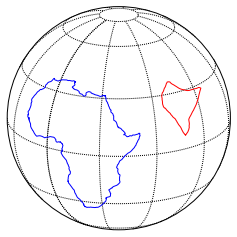

In [22]:
m = Basemap(projection='ortho',lon_0=40,lat_0=20) # make a map object
m.drawparallels(np.arange(-90.,120.,30.)) # put on the latitudes
m.drawmeridians(np.arange(0.,390.,30.)) # put on the longitudes
# read in africa's outline
af_data=np.array(poleRot.get_continent('af')).transpose()
lats=af_data[0]  # fish out the latitudes
lons=af_data[1] # fish out the longitudes
x,y=m(lons,lats) # transform to map coordinates
plt.plot(x,y,'b-') # plot them as a blue line
## then do the same for India
ind_data=np.array(poleRot.get_continent('ind')).transpose()
lats=ind_data[0] 
lons=ind_data[1]
x,y=m(lons,lats)
plt.plot(x,y,'r-');


#


Now we can step through time to make a series of images as India peels off from Africa and moves north:

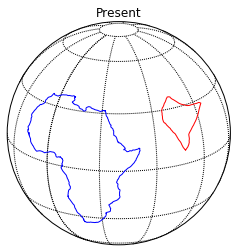

In [25]:
Ages=range(110,0,-5) # do 10 Ma steps
m = Basemap(projection='ortho',lon_0=40,lat_0=20)
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,390.,30.));
# get Africa's coordinates
af_data=np.array(poleRot.get_continent('af')).transpose()
lats=af_data[0] 
lons=af_data[1]
# now do India's coordinates
ind_data=np.array(poleRot.get_continent('ind')).transpose()
lats=ind_data[0] 
lons=ind_data[1]
# step through ages for movie
cnt=0 # this is a counter for the figure names. 
for age in Ages:
    plt.clf() # each time we plot a map we need to clear off the old one.  
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,390.,30.))
    x,y=m(af_data[1],af_data[0])
    plt.plot(x,y,'b-') # put good old Africa on
    # get the pole of rotation for india at the desired age
    pole=poleRot.get_pole('ind',age) 
    rotlats,rotlons=poleRot.PTrot(pole,ind_data[0],ind_data[1]) # do the rotation
    x,y=m(rotlons,rotlats) # convert to map coordinates
    plt.plot(x,y,'-r') 
    num=str(cnt) # make a string of the figure number
    cnt+=1 # increment that
    while len(num)<3:num='0'+num # pad the figure number with 00's
    plt.title(str(age)+' Ma') # put on  a title
    plt.savefig('ContRot/contRot_'+num+'.png') # save the figure
plt.clf()
# let's do the present too
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,390.,30.))
x,y=m(af_data[1],af_data[0] )
plt.plot(x,y,'b-')
x,y=m(ind_data[1],ind_data[0] )
plt.plot(x,y,'r-')
num=str(cnt)
while len(num)<3:num='0'+num
plt.title('Present')
plt.savefig('ContRot/contRot_'+num+'.png')



In [26]:
filenames=os.listdir('ContRot/') # listing of the directory
images = [] # make a container to put the image files in
for file in filenames: # step through all the maps
    if 'png' in file: # skip some of the nasty hidden files
        filename='ContRot/'+file # make filename from the folder name and the file name
        images.append(imageio.imread(filename)) # read it in and stuff in the container
imageio.mimsave('ContRot/ContRot.gif', images) # save to an animated gif.  

And, as before,  you can open the animated gif **ContRot.gif** under the File menu. Or, embed it in this notebook: 

In [28]:
HTML('<img src="ContRot/ContRot.gif">')

There is even an animation modules in matplotlib.  To find out more, check out this website: 

http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

